# Table of contents

1. [Importing Libraries & Loading Data](#Importing)
2. [Cleaning & Preparing Data](#Clean&Prep)
    1. [Renaming columns](#Renaming)
    2. [Dropping bad data](#DropBadData)
    3. [Resetting values & types](#ResetValues)
3. [Populating Null Values](#PopulatingNulls)
4. [Adding Metrics & Features](#AddingMetrics)
5. [Exploratory Data Analysis](#EDA)
    1. [General EDA](#GenEDA)
    2. [Feature EDA](#FeatEDA)
6. [EDA & Model for Null BsmtQual](#BsmtEDA)
7. [Model Testing](#ModelTesting)
    1. [Setting models](#SettingModels)
    2. [Testing models](#TestingModels)
    3. [Grid search optimization](#GridSearch)
    4. [Visualizing model](#VisualModel)
8. [Running Model on Test Data](#RunningModel)

# 1) Importing Libraries & Loading Data<a name="Importing"></a>

In [1]:
#### TO DO IN FUTURE ####
## 1) Improve BsmtQual fill model for Nulls in test data
## 2) Add new features (lot area??) ## Would need to get creative on building new one ##
## 3) Remove low impact features as I add higher impact one
## 4) Better clean the data...
## 5) Figure out a way to be smarter to weight inputs into meta-features (ie. TotalArea)
#### TO DO IN FUTURE ####

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error
from IPython.display import display
from scipy import stats
pd.options.display.max_columns = None

%matplotlib inline

In [3]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

# 2) Cleaning & Preparing Data<a name="Clean&Prep"></a>

### Renaming columns<a name="Renaming"></a>

In [4]:
## Function to replace spaces in the column titles
def remove_space(df):
    col_no_space = []
    for col in list(df.columns):
        col_no_space.append(col.replace(' ',''))
    return col_no_space

## Removing spaces from column titles in both test sets
train.columns = remove_space(train)
test.columns = remove_space(test)

### Dropping bad data<a name="DropBadData"></a>

In [5]:
## Dropping all columns from train data where more than 40% of the data is missing
train.drop(columns=['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'], inplace=True)

### Resetting values & types<a name="ResetValues"></a>

In [6]:
## Converting CentralAir to binary
train['CentralAir'] = [1 if x =='Y' else 0 for x in train['CentralAir']]
test['CentralAir'] = [1 if x =='Y' else 0 for x in test['CentralAir']]

## Set MSSubClass to a series of strings (categorical)
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

In [7]:
## Sets dictionary to recategorize quality as numeric value (higher = better)
recat_dict = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1,
    'Na' : 0,
    'GLQ' : 6,
    'ALQ' : 5,
    'BLQ' : 4,
    'Rec' : 3,
    'LwQ' : 2,
    'Unf' : 1,
    'NA' : 0,
    'Av' : 3,
    'Mn' : 2,
    'No' : 1,
    'Fin' : 3,
    'RFn' : 2
    
}

## Replaces quality indices with numeric values
train.replace(to_replace=recat_dict, inplace=True)
test.replace(to_replace=recat_dict, inplace=True)

## Changes these types to a float
train[['ExterQual','BsmtQual','KitchenQual','GarageQual','BsmtFinType1','BsmtFinType2',
      'HeatingQC','GarageCond','BsmtExposure']] = \
train[['ExterQual','BsmtQual','KitchenQual','GarageQual','BsmtFinType1','BsmtFinType2',
      'HeatingQC','GarageCond','BsmtExposure']].astype(float)

test[['ExterQual','BsmtQual','KitchenQual','GarageQual','BsmtFinType1','BsmtFinType2',
      'HeatingQC','GarageCond','BsmtExposure']] = \
test[['ExterQual','BsmtQual','KitchenQual','GarageQual','BsmtFinType1','BsmtFinType2',
      'HeatingQC','GarageCond','BsmtExposure']].astype(float)

### NOTE: I tested a few of these beforehand to make sure the numeric scales had higher correlations than
### any of the dummy variables. I find that using numbers make sense and the correlations seem
### stronger than creating dummy variables for Quality

# 3) Populating null values<a name="PopulatingNulls"></a>

#### Test Data: Basement Quality
In the test data, basement quality (BsmtQual) had a number of Null or NaN values. Since the feature is paramount to the final model, a sub-model (EDA below) was used to fill in these Nulls.

In [8]:
## Setting up X and y for filling in Basement Quality on test data
bsmt_qual_filter = ['BsmtQual','YearBuilt','OverallQual','ExterQual','KitchenQual']
bq_df = test[bsmt_qual_filter].dropna()
y_test_bq = bq_df['BsmtQual']
X_test_bq = bq_df[bsmt_qual_filter].drop(columns=['BsmtQual'])

In [9]:
## Instantiating ridge model and standard scaler
ridge = RidgeCV(cv=5)
SS = StandardScaler()

## Scaling the X data
X_test_bq_s = SS.fit_transform(X_test_bq)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
## Fitting the model
ridge.fit(X_test_bq_s, y_test_bq)
X_test_bq_full = test[bsmt_qual_filter].drop(columns=['BsmtQual'])
X_test_bq_full_s = SS.transform(X_test_bq_full)

## Predicting Basement Quality
test['BsmtQualPreds'] = ridge.predict(X_test_bq_full_s)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [11]:
## Filling Test BsmtQual Nulls with predictions
test['BsmtQual'].fillna(value=test['BsmtQualPreds'], inplace=True)

# 4) Adding Metrics & Features<a name="AddingMetrics"></a>

In [12]:
## Defining new metric for how old the house is
train['HouseAge'] = 2019 - train['YearBuilt']
test['HouseAge'] = 2019 - test['YearBuilt']

#### This ended up not being used.

In [13]:
## Defining new metric for the total area of the house based on combination of individual house areas
#### NOTE: Weighted according to strength of correlation.
#### NOTE: TotalArea is not actually in square feet anymore

train['TotalArea'] = (0.628925 * train['TotalBsmtSF']) + (0.697038 * train['GrLivArea'])\
+ (0.650270*train['GarageArea']) - (0.045328*train['LowQualFinSF'])

test['TotalArea'] = (0.628925 * test['TotalBsmtSF']) + (0.697038 * test['GrLivArea'])\
+ (0.650270*test['GarageArea']) - (0.045328*test['LowQualFinSF'])

In [14]:
## Defining new metric for total Quality
#### NOTE: Weighted according to strength of correlation.

train['QualMetric'] = (0.692336*train['KitchenQual']) + (0.678307*train['BsmtQual']) + \
(0.712146*train['ExterQual']) + (0.800207*train['OverallQual'])

test['QualMetric'] = (0.692336*test['KitchenQual']) + (0.678307*test['BsmtQual']) + \
(0.712146*test['ExterQual']) + (0.800207*test['OverallQual'])

In [15]:
## Defining new metric for Total Baths
#### NOTE: Half baths are multiplied by... wait for it... half
#### This intuitively makes sense and seems to drive stronger correlations

train['TotalBaths'] = train['BsmtFullBath'] + train['FullBath'] + \
(0.5*train['HalfBath']) + (0.5*train['BsmtHalfBath'])

test['TotalBaths'] = test['BsmtFullBath'] + test['FullBath'] + \
(0.5*test['HalfBath']) + (0.5*test['BsmtHalfBath'])

In [16]:
## Defining new metric for total Porch or Deck Area
#### NOTE: Weighting by correlations didn't add value here.

train['PorchArea'] = train['ScreenPorch'] + train['3SsnPorch']\
+ train['OpenPorchSF'] + train['EnclosedPorch'] + train['WoodDeckSF']

test['PorchArea'] = test['ScreenPorch'] + test['3SsnPorch']\
+ test['OpenPorchSF'] + test['EnclosedPorch'] + test['WoodDeckSF']

In [17]:
## Defining function to find and return DataFrame with only the dummy variables that
## have a correlation > 0.15

def find_corr_dummies(df,col,target):
    temp_dumms_corr = pd.get_dummies(df[[col,target]]).corr()[target]
    temp_dumms_corr = list(temp_dumms_corr[abs(temp_dumms_corr) > .15].index.drop(target))
    return pd.get_dummies(df)[temp_dumms_corr]

#### FUTURE CODE: While this works well with train data, where target is known, it doesn't work so hot
#### with the test data. I'd have this return a list of column names in the future so it's more widely usable

In [18]:
## Adding Neighborhoods with strong correlations to my train data
train = pd.concat([train,find_corr_dummies(train,'Neighborhood','SalePrice')], axis=1)

## Adding Neighborhoods with strong correlations to my test data
#### As addressed above, I couldn't apply find_corr_dummies to the test data (or use its output)
test = pd.concat([test, 
                  pd.get_dummies(test)[['Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
        'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
        'Neighborhood_Somerst', 'Neighborhood_StoneBr']]],
                 axis=1)

In [19]:
## Adding strong correlations for MSSubClass
#### NOTE: I never added this to test because the correlations were insignificant
train = pd.concat([train,find_corr_dummies(train,'MSSubClass','SalePrice')], axis=1)

In [20]:
## Adding a variable for the mansions found in the data that are cheap for their other features
## 2 mansions were identified that drove high MSE and lay way outside the expectations
train['mansion'] = [1 if x > 5000 else 0 for x in train['TotalArea']]
test['mansion'] = [1 if x > 5000 else 0 for x in test['TotalArea']]

In [21]:
## EDA Identified a skew in the target, so log is used to make target more normal
train['SalePriceLog'] = np.log(train['SalePrice'])

# 5) Exploratory Data Analysis<a name="EDA"></a>

### General EDA<a name="GenEDA"></a>

In [22]:
## Perusing columns and data
train.head()

,Id,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SalePrice,HouseAge,TotalArea,QualMetric,TotalBaths,PorchArea,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,MSSubClass_30,MSSubClass_50,MSSubClass_60,mansion,SalePriceLog
0,109,533352170,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4.0,3,CBlock,3.0,3.0,1.0,6.0,533.0,1.0,0.0,192.0,725.0,GasA,5.0,1,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,4.0,6,Typ,0,Attchd,1976.0,2.0,2.0,475.0,3.0,3.0,Y,0,44,0,0,0,0,0,3,2010,WD,130500,43,1795.768077,12.454091,2.5,44,0,0,0,0,0,0,0,0,0,0,1,0,11.779129
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4.0,3,PConc,4.0,3.0,1.0,6.0,637.0,1.0,0.0,276.0,913.0,GasA,5.0,1,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,4.0,8,Typ,1,Attchd,1997.0,2.0,2.0,559.0,3.0,3.0,Y,0,74,0,0,0,0,0,4,2009,WD,220000,23,2416.824091,13.932605,3.5,74,0,0,0,0,0,0,0,0,0,0,1,0,12.301383
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3.0,4,CBlock,3.0,3.0,1.0,6.0,731.0,1.0,0.0,326.0,1057.0,GasA,3.0,1,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,4.0,5,Typ,0,Detchd,1953.0,1.0,1.0,246.0,3.0,3.0,Y,0,52,0,0,0,0,0,1,2010,WD,109000,66,1561.509311,10.941738,2.0,52,0,0,1,0,0,0,0,0,0,0,0,0,11.599103
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3.0,3,PConc,4.0,3.0,1.0,1.0,0.0,1.0,0.0,384.0,384.0,GasA,4.0,1,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,3.0,7,Typ,0,BuiltIn,2007.0,3.0,2.0,400.0,3.0,3.0,Y,100,0,0,0,0,0,0,4,2010,WD,174000,13,1508.138072,10.927709,2.5,100,0,0,0,0,0,0,0,0,0,0,1,0,12.066811
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3.0,3,PConc,2.0,4.0,1.0,1.0,0.0,1.0,0.0,676.0,676.0,GasA,3.0,1,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,3.0,6,Typ,0,Detchd,1957.0,1.0,2.0,484.0,3.0,3.0,N,0,59,0,0,0,0,0,3,2010,WD,138500,119,1747.103890,10.371302,2.0,59,0,0,0,0,0,0,0,0,0,1,0,0,11.838626


In [23]:
## Learning about the data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 94 columns):
Id                      2051 non-null int64
PID                     2051 non-null int64
MSSubClass              2051 non-null object
MSZoning                2051 non-null object
LotFrontage             1721 non-null float64
LotArea                 2051 non-null int64
Street                  2051 non-null object
LotShape                2051 non-null object
LandContour             2051 non-null object
Utilities               2051 non-null object
LotConfig               2051 non-null object
LandSlope               2051 non-null object
Neighborhood            2051 non-null object
Condition1              2051 non-null object
Condition2              2051 non-null object
BldgType                2051 non-null object
HouseStyle              2051 non-null object
OverallQual             2051 non-null int64
OverallCond             2051 non-null int64
YearBuilt               2051 non-null int6

In [24]:
## Identifying the percent of data missing from coumns missing more than 0% of data
train[list(train.columns[train.isna().any()])].isna().sum()/2051

LotFrontage     0.160897
MasVnrType      0.010726
MasVnrArea      0.010726
BsmtQual        0.026816
BsmtCond        0.026816
BsmtExposure    0.028279
BsmtFinType1    0.026816
BsmtFinSF1      0.000488
BsmtFinType2    0.027304
BsmtFinSF2      0.000488
BsmtUnfSF       0.000488
TotalBsmtSF     0.000488
BsmtFullBath    0.000975
BsmtHalfBath    0.000975
GarageType      0.055095
GarageYrBlt     0.055583
GarageFinish    0.055583
GarageCars      0.000488
GarageArea      0.000488
GarageQual      0.055583
GarageCond      0.055583
TotalArea       0.000975
QualMetric      0.026816
TotalBaths      0.000975
dtype: float64

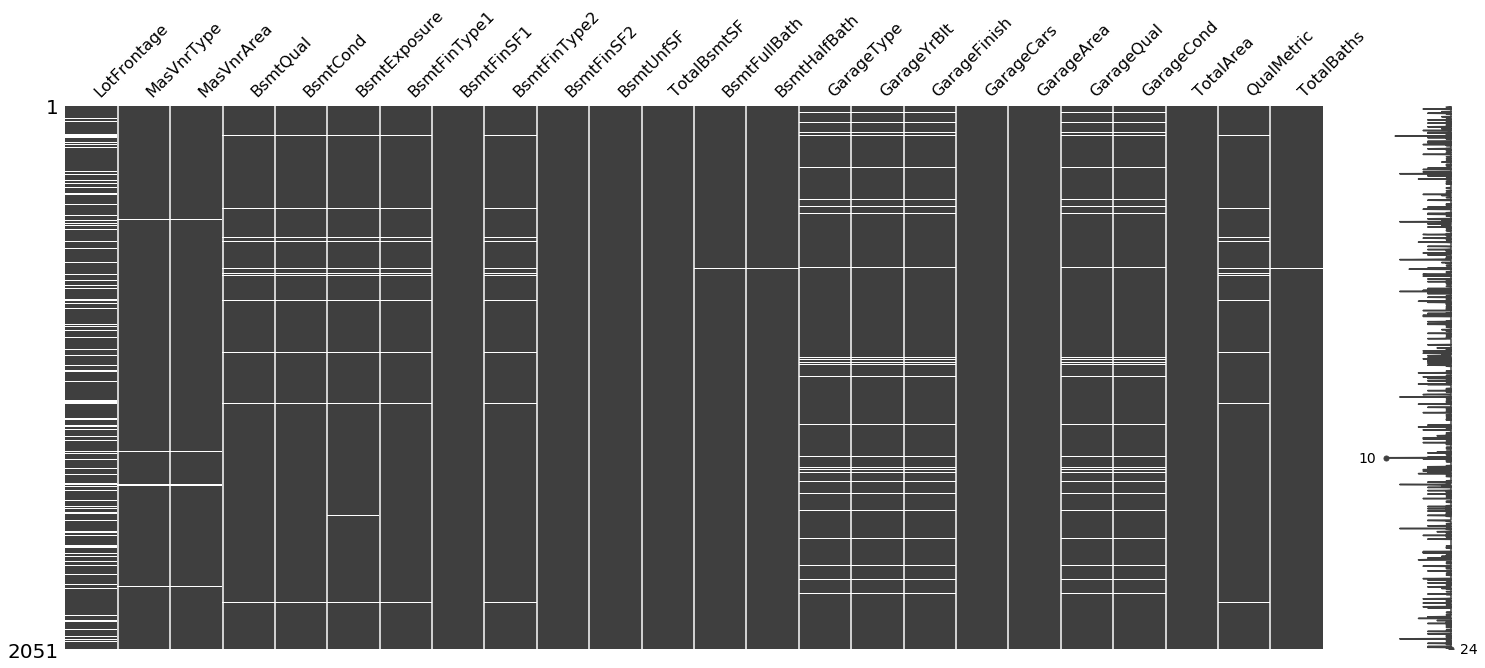

In [25]:
## Visual representation of where missing data is
msno.matrix(train[train.columns[train.isna().any()].tolist()]);

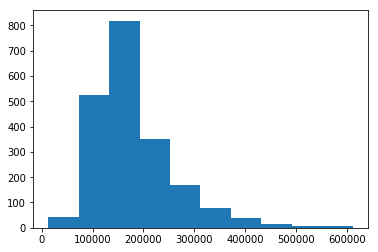

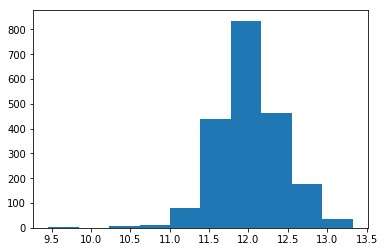

In [26]:
## Examining the skew of target SalePrice
plt.hist(train['SalePrice']);
plt.show()

## Since it looks like there is a skew, below examines the log to see if that normalizes the target
plt.hist(train['SalePriceLog']);

#### Log(sale price) has a more normal distribution so I will use that as the target
#### NOTE: Exponent will be taken later

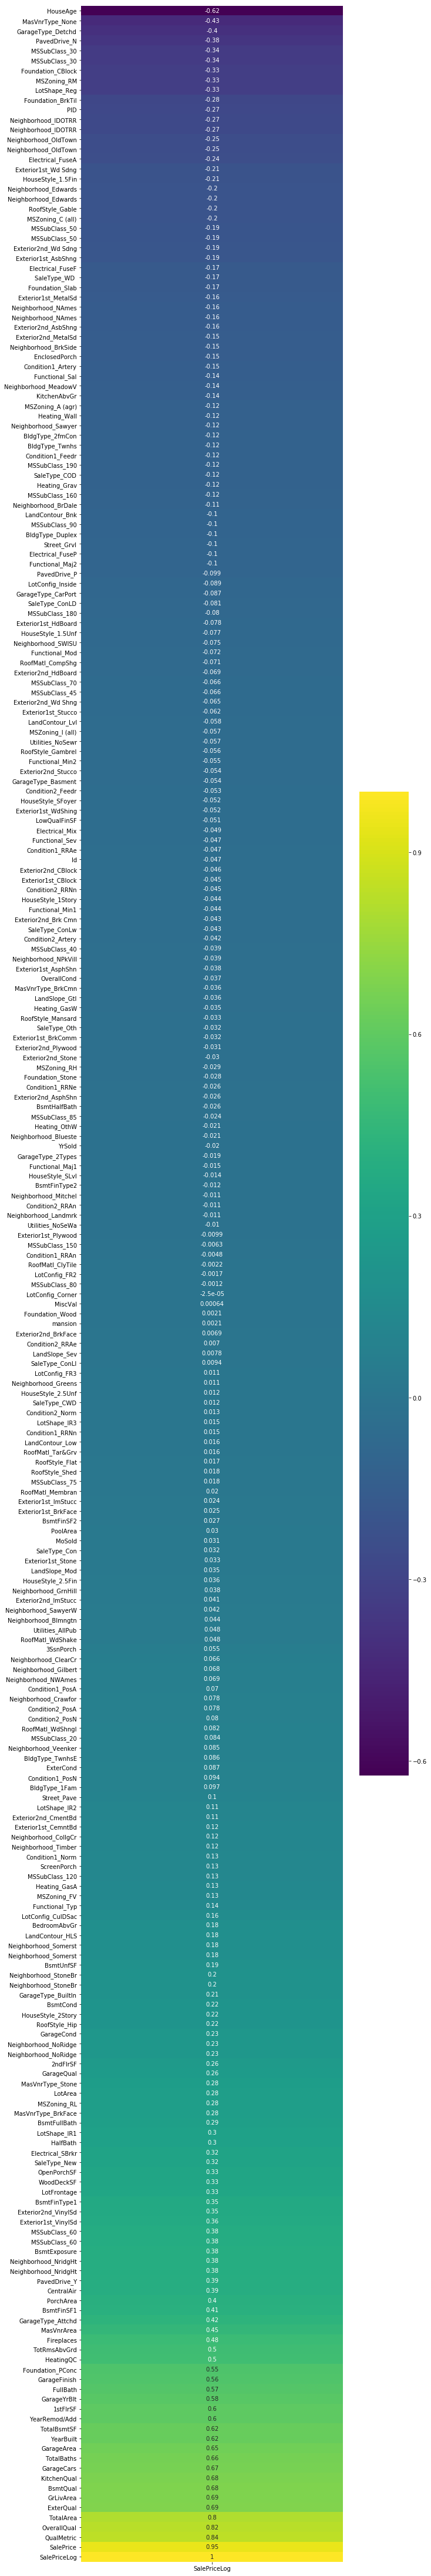

In [27]:
## Heatmap to get a look at ALL possible correlations or features
plt.figure(figsize=(10,80))
sns.heatmap(pd.get_dummies(train).corr()[['SalePriceLog']].sort_values('SalePriceLog'),
            cmap='viridis', annot=True);                                 


### Feature EDA<a name="FeatEDA"></a>

In [28]:
### Function to create multiple scatter plots in one figure plot
#### CODE BORROWED: Project 1
def subplot_scatters(dataframe, list_of_x_cols, list_of_y_cols, list_of_x_labels, list_of_y_labels, list_of_titles):
    nrows = int(np.ceil(len(list_of_x_cols)/2)) # Number of rows needed
    fig, ax = plt.subplots(nrows=nrows, ncols=2, 
                           figsize=(16,round((len(list_of_x_cols)+len(list_of_x_cols)%2)*2))) # Nice flex spacing
    ax = ax.ravel() # Makes it easier to iterate
    plt.subplots_adjust(hspace = .4) # Nice padding
    for i, column in enumerate(list_of_x_cols): # Gives us an index value to get into all our lists
        ax[i].scatter(dataframe[column], dataframe[list_of_y_cols[i]]) # Calls on (x, y) inputs
        ax[i].set_title(list_of_titles[i]) # Set title
        ax[i].set_xlabel(list_of_x_labels[i]) # Set x-axis label
        ax[i].set_ylabel(list_of_y_labels[i]) # Set y-axis label

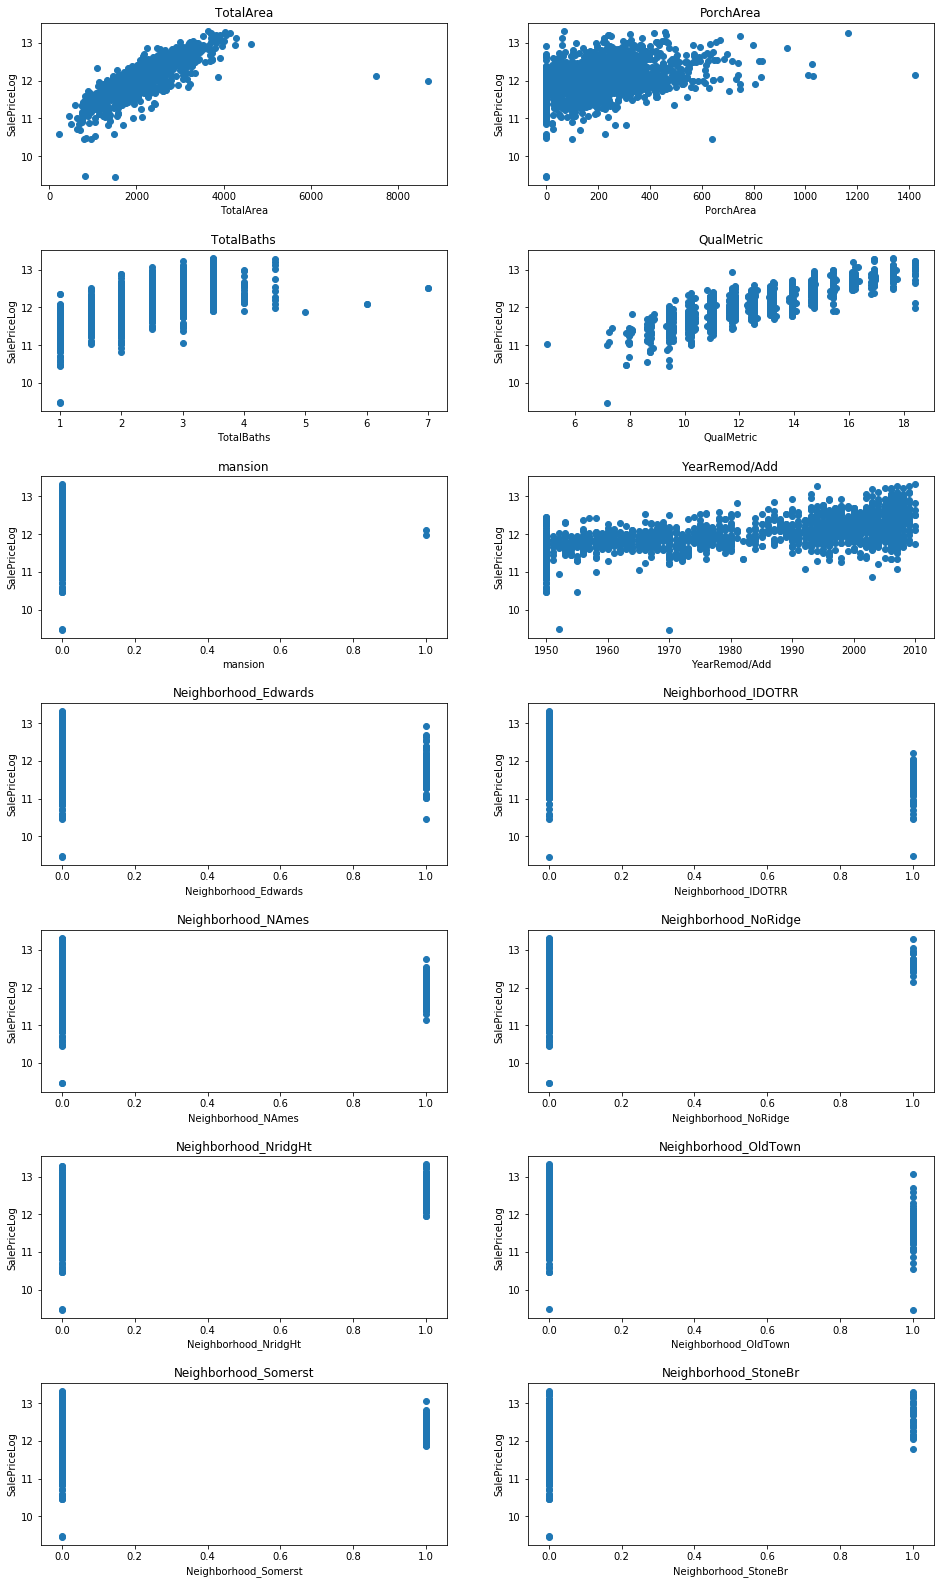

In [29]:
## Plotting all the included variables against the SalePriceLog
subplot_scatters(train,
                ['TotalArea','PorchArea','TotalBaths','QualMetric','mansion','YearRemod/Add',
                'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
               'Neighborhood_NoRidge', 'Neighborhood_NridgHt','Neighborhood_OldTown',
                 'Neighborhood_Somerst', 'Neighborhood_StoneBr'],
                
                ['SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog',
                'SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog',
                'SalePriceLog','SalePriceLog'],
                
                ['TotalArea','PorchArea','TotalBaths','QualMetric','mansion','YearRemod/Add',
                'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
               'Neighborhood_NoRidge', 'Neighborhood_NridgHt','Neighborhood_OldTown',
                 'Neighborhood_Somerst', 'Neighborhood_StoneBr'],
                
                ['SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog',
                'SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog','SalePriceLog',
                'SalePriceLog','SalePriceLog'],
                
                ['TotalArea','PorchArea','TotalBaths','QualMetric','mansion','YearRemod/Add',
                'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
               'Neighborhood_NoRidge', 'Neighborhood_NridgHt','Neighborhood_OldTown',
                 'Neighborhood_Somerst', 'Neighborhood_StoneBr'])

In [30]:
## Looking for colinearity and correlation to target from features around AREA or SIZE
train[['TotalBsmtSF','GrLivArea','GarageArea','1stFlrSF',
       '2ndFlrSF','BsmtFinSF2','BsmtUnfSF','LowQualFinSF','SalePriceLog']].corr()

,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF,2ndFlrSF,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,SalePriceLog
TotalBsmtSF,1.000000,0.453635,0.488805,0.808756,-0.217351,0.086545,0.419238,-0.022449,0.621416
GrLivArea,0.453635,1.000000,0.490949,0.562441,0.639092,0.001083,0.234618,0.106266,0.687774
GarageArea,0.488805,0.490949,1.000000,0.498712,0.121286,0.013190,0.145080,-0.071190,0.650755
1stFlrSF,0.808756,0.562441,0.498712,1.000000,-0.268855,0.095675,0.302299,-0.010399,0.599086
2ndFlrSF,-0.217351,0.639092,0.121286,-0.268855,1.000000,-0.087505,-0.012928,0.014645,0.256771
BsmtFinSF2,0.086545,0.001083,0.013190,0.095675,-0.087505,1.000000,-0.231330,-0.002764,0.026541
BsmtUnfSF,0.419238,0.234618,0.145080,0.302299,-0.012928,-0.231330,1.000000,0.059575,0.193935
LowQualFinSF,-0.022449,0.106266,-0.071190,-0.010399,0.014645,-0.002764,0.059575,1.000000,-0.051124
SalePriceLog,0.621416,0.687774,0.650755,0.599086,0.256771,0.026541,0.193935,-0.051124,1.000000


In [31]:
## Looking for colinearity and correlation to target from features around QUALITY
train[['OverallQual','KitchenQual','BsmtQual','GarageQual','ExterQual','GarageCond','SalePriceLog']].corr()

,OverallQual,KitchenQual,BsmtQual,GarageQual,ExterQual,GarageCond,SalePriceLog
OverallQual,1.000000,0.690639,0.680455,0.208853,0.740257,0.173415,0.822774
KitchenQual,0.690639,1.000000,0.594840,0.133284,0.730562,0.107243,0.681550
BsmtQual,0.680455,0.594840,1.000000,0.163286,0.661594,0.139641,0.683721
GarageQual,0.208853,0.133284,0.163286,1.000000,0.152579,0.516401,0.259619
ExterQual,0.740257,0.730562,0.661594,0.152579,1.000000,0.099125,0.690333
GarageCond,0.173415,0.107243,0.139641,0.516401,0.099125,1.000000,0.232281
SalePriceLog,0.822774,0.681550,0.683721,0.259619,0.690333,0.232281,1.000000


In [32]:
## Looking for colinearity and correlation to target from features around BATHROOMS
train[['BsmtFullBath','FullBath','HalfBath','BsmtHalfBath','SalePriceLog']].corr()

#### NOTE: The negative correlation on BsmtHalfBath was concerning, but in the end that may be confounding
#### variables. The TotalBath-SalePrice correlation seemed to be stronger when BsmtHalfBath was included.

,BsmtFullBath,FullBath,HalfBath,BsmtHalfBath,SalePriceLog
BsmtFullBath,1.000000,-0.010790,-0.025954,-0.146894,0.286193
FullBath,-0.010790,1.000000,0.153656,-0.060099,0.565855
HalfBath,-0.025954,0.153656,1.000000,-0.047309,0.300542
BsmtHalfBath,-0.146894,-0.060099,-0.047309,1.000000,-0.026018
SalePriceLog,0.286193,0.565855,0.300542,-0.026018,1.000000


In [33]:
## Looking for colinearity and correlation to target from features around OUTDOOR PORCH/DECK
train[['PorchArea','ScreenPorch','3SsnPorch','OpenPorchSF','EnclosedPorch','WoodDeckSF','SalePriceLog']].corr()

#### NOTE: The negative correlation on EnclosedPorch was concerning, but in the end that may be confounding
#### variables. The PorchArea-SalePrice correlation seemed to be stronger when BsmtHalfBath was included.

,PorchArea,ScreenPorch,3SsnPorch,OpenPorchSF,EnclosedPorch,WoodDeckSF,SalePriceLog
PorchArea,1.000000,0.298058,0.123189,0.446315,0.220258,0.754074,0.399929
ScreenPorch,0.298058,1.000000,-0.029574,0.059027,-0.069049,-0.067770,0.125983
3SsnPorch,0.123189,-0.029574,1.000000,-0.007336,-0.032145,-0.010851,0.054918
OpenPorchSF,0.446315,0.059027,-0.007336,1.000000,-0.077019,0.047630,0.328268
EnclosedPorch,0.220258,-0.069049,-0.032145,-0.077019,1.000000,-0.114079,-0.149210
WoodDeckSF,0.754074,-0.067770,-0.010851,0.047630,-0.114079,1.000000,0.330145
SalePriceLog,0.399929,0.125983,0.054918,0.328268,-0.149210,0.330145,1.000000


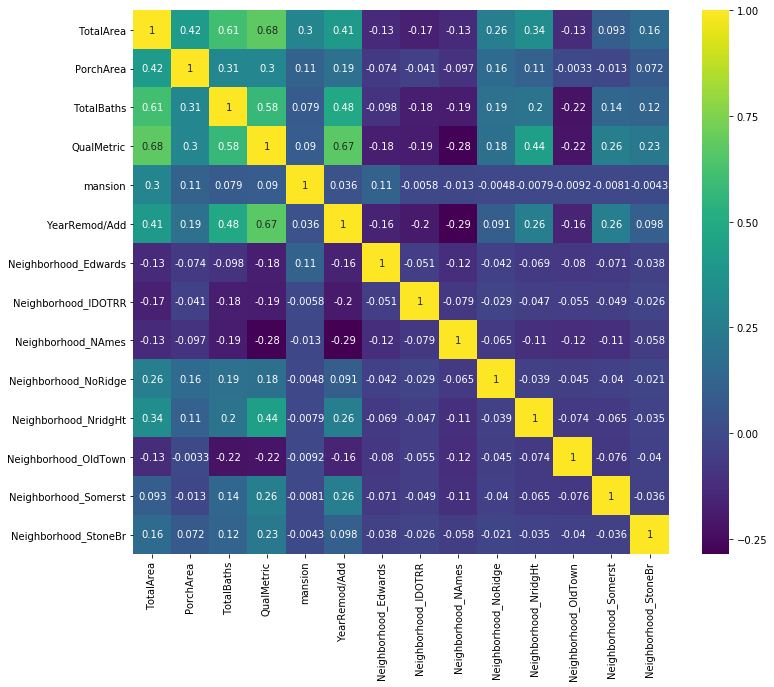

In [34]:
## Checking out correlations on all key features
plt.figure(figsize=(12,10))
sns.heatmap(train[['TotalArea','PorchArea','TotalBaths','QualMetric','mansion','YearRemod/Add',
                'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
               'Neighborhood_NoRidge', 'Neighborhood_NridgHt','Neighborhood_OldTown',
                 'Neighborhood_Somerst', 'Neighborhood_StoneBr']].corr(),
            annot=True,
           cmap='viridis');

#### Some metrics are fairly correlated, but I'm not overly worried about colinearity
#### QualMetric-TotalArea (0.68) is somewhat concerning but these are fundamental features
#### QualMetric-YearRemod/Add (0.67) concerns me more – since YearRemod/Add doesn't 
#### add too much value

# 6) EDA & Model for Null BsmtQual<a name="BsmtEDA"></a>
Designing the model for filling in Nulls in BsmtQual in Test data. Model was applied above.

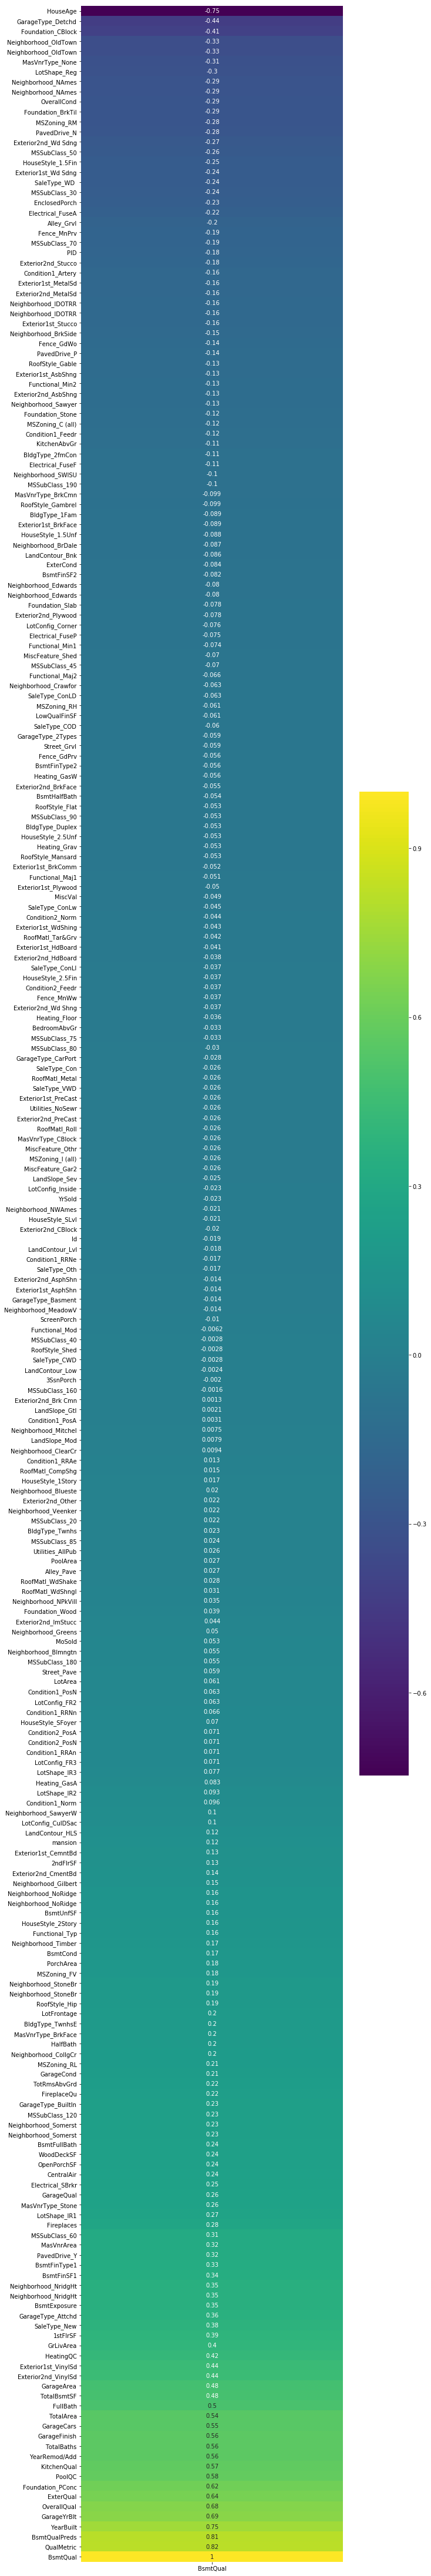

In [35]:
## Examining strongly correlated variables
plt.figure(figsize=(10,80))
sns.heatmap(pd.get_dummies(test).corr()[['BsmtQual']].sort_values('BsmtQual'),
            cmap='viridis', annot=True);                                 

#### Identified 'YearBuilt','OverallQual','HouseAge','ExterQual','KitchenQual' as variables I want to use

In [36]:
## Examining the variables for Nulls. I don't want to do third-level modeling
## (A model to predict features for a model to features for a model to predict SalePrice)
test[['YearBuilt','OverallQual','HouseAge','ExterQual','KitchenQual']].isna().sum()

YearBuilt      0
OverallQual    0
HouseAge       0
ExterQual      0
KitchenQual    0
dtype: int64

In [37]:
## Setting my X and y.
bsmt_qual_filter = ['BsmtQual','YearBuilt','OverallQual','ExterQual','KitchenQual']
bq_df = test[bsmt_qual_filter].dropna() ## There are no Nulls, but I like this method b/c it pushes regardless
y_test_bq = bq_df['BsmtQual']
X_test_bq = bq_df[bsmt_qual_filter].drop(columns=['BsmtQual'])

In [38]:
## Instantiating various models to try out
lr = LinearRegression()
lasso = LassoCV(cv=5)
ridge = RidgeCV(cv=5)
elast = ElasticNetCV(cv=5)

SS = StandardScaler()

X_test_bq_s = SS.fit_transform(X_test_bq)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [39]:
## Printout of key scores I want to evaluate my model with
print("Linear Regression\nCross Val Scores: ",
      cross_val_score(lr, X_test_bq_s, y_test_bq, cv=5))

print("Avg. CV Score: ", round(cross_val_score(lr,  X_test_bq_s, y_test_bq, cv=5).mean(),5))
print("\nLasso\nCross Val Score: ",
      cross_val_score(lasso,  X_test_bq_s, y_test_bq, cv=5))

print("Avg. CV Score: ", round(cross_val_score(lasso,  X_test_bq_s, y_test_bq, cv=5).mean(),5))
print("\nRidge\nCross Val Score: ", 
      cross_val_score(ridge,  X_test_bq_s, y_test_bq, cv=5))

print("Avg. CV Score: ", round(cross_val_score(ridge,  X_test_bq_s, y_test_bq, cv=5).mean(),5))
print("\nElastic Net\nCross Val Score: ", 
      cross_val_score(elast,  X_test_bq_s, y_test_bq, cv=5))

print("Avg. CV Score: ", round(cross_val_score(elast,  X_test_bq_s, y_test_bq, cv=5).mean(),5))

#### All pretty much identical... I will take Ridge

Linear Regression
Cross Val Scores:  [0.70442061 0.63686053 0.64545547 0.65924357 0.63319184]
Avg. CV Score:  0.65583

Lasso
Cross Val Score:  [0.70440949 0.63682327 0.64556353 0.65923178 0.63314592]
Avg. CV Score:  0.65583

Ridge
Cross Val Score:  [0.70446713 0.63679801 0.64770391 0.65811546 0.63262803]
Avg. CV Score:  0.65594

Elastic Net
Cross Val Score:  [0.70442639 0.63676878 0.64563551 0.65910292 0.63307855]
Avg. CV Score:  0.6558


# 7) Model Testing<a name="ModelTesting"></a>

### Setting models<a name="SettingModels"></a>

In [40]:
## Setting X & y
train_filter = ['Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
                'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'TotalArea',
       'QualMetric', 'TotalBaths', 'PorchArea','mansion','YearRemod/Add','SalePriceLog','SalePrice']
df = train[train_filter].dropna() ## Switching to a more manageable dataframe here
y = df['SalePriceLog']
X = df[train_filter].drop(columns=['SalePriceLog','SalePrice'])

In [41]:
## Instantiating models and transformers I want to test out
lr = LinearRegression()
lasso = LassoCV(cv=5)
ridge = RidgeCV(cv=5)
elast = ElasticNetCV(cv=5)
SS = StandardScaler()
pt= PowerTransformer()

### Testing models<a name="TestingModels"></a>

In [42]:
## Printout of key scores I want to evaluate my model with
## NO POWER TRANSFORMATION

X_scaled = SS.fit_transform(X)

print("Linear Regression\nCross Val Scores: ",
      cross_val_score(lr, X_scaled, y, cv=5))
print("Avg. CV Score: ", round(cross_val_score(lr, X_scaled, y, cv=5).mean(),5))

print("\nLasso\nCross Val Score: ",
      cross_val_score(lasso, X_scaled, y, cv=5))
print("Avg. CV Score: ", round(cross_val_score(lasso, X_scaled, y, cv=5).mean(),5))

print("\nRidge\nCross Val Score: ", 
      cross_val_score(ridge, X_scaled, y, cv=5))
print("Avg. CV Score: ", round(cross_val_score(ridge, X_scaled, y, cv=5).mean(),5))

print("\nElastic Net\nCross Val Score: ", 
      cross_val_score(elast, X_scaled, y, cv=5))
print("Avg. CV Score: ", round(cross_val_score(elast, X_scaled, y, cv=5).mean(),5))

#### I liked Ridge though they were all VERY similar

Linear Regression
Cross Val Scores:  [0.85402357 0.8754069  0.89684612 0.8177542  0.89007159]
Avg. CV Score:  0.86682


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)



Lasso
Cross Val Score:  [0.85399199 0.87552365 0.89660687 0.81761253 0.89031015]
Avg. CV Score:  0.86681

Ridge
Cross Val Score:  [0.85405782 0.87548454 0.89688957 0.81744141 0.89037612]
Avg. CV Score:  0.86685

Elastic Net
Cross Val Score:  [0.85399479 0.87552873 0.89661017 0.8175968  0.89042783]
Avg. CV Score:  0.86683


In [43]:
## Same test but trying out the PowerTransformer
## POWER TRANSFORMATION
X_scaled_pt = pt.fit_transform(X)

## Printout of key scores I want to evaluate my model with
print("Linear Regression\nCross Val Scores: ",
      cross_val_score(lr, X_scaled, y, cv=5))

print("Avg. CV Score: ", round(cross_val_score(lr, X_scaled, y, cv=5).mean(),5))
print("\nLasso\nCross Val Score: ",
      cross_val_score(lasso, X_scaled, y, cv=5))

print("Avg. CV Score: ", round(cross_val_score(lasso, X_scaled, y, cv=5).mean(),5))
print("\nRidge\nCross Val Score: ", 
      cross_val_score(ridge, X_scaled, y, cv=5))

print("Avg. CV Score: ", round(cross_val_score(ridge, X_scaled, y, cv=5).mean(),5))
print("\nElastic Net\nCross Val Score: ", 
      cross_val_score(elast, X_scaled, y, cv=5))

print("Avg. CV Score: ", round(cross_val_score(elast, X_scaled, y, cv=5).mean(),5))

#### Ridge, with the power transformation, seems marginally better than the others

Linear Regression
Cross Val Scores:  [0.85402357 0.8754069  0.89684612 0.8177542  0.89007159]
Avg. CV Score:  0.86682


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



Lasso
Cross Val Score:  [0.85399199 0.87552365 0.89660687 0.81761253 0.89031015]
Avg. CV Score:  0.86681

Ridge
Cross Val Score:  [0.85405782 0.87548454 0.89688957 0.81744141 0.89037612]
Avg. CV Score:  0.86685

Elastic Net
Cross Val Score:  [0.85399479 0.87552873 0.89661017 0.8175968  0.89042783]
Avg. CV Score:  0.86683


In [44]:
## Instantiating a Ridge model
ridge = Ridge()

## Examining coefficients to see what helped here
ridge.fit(X_scaled_pt, y)
print('Ridge Alpha: ', ridge.alpha)
for l, c in zip(train_filter, ridge.coef_):
    print(l, c)

Ridge Alpha:  1.0
Neighborhood_Edwards -0.012914180069983112
Neighborhood_IDOTRR -0.024375232677200608
Neighborhood_NAmes 0.008059626430237688
Neighborhood_NoRidge 0.014042803004833704
Neighborhood_NridgHt 0.019148785603793027
Neighborhood_OldTown -0.03292339014284213
Neighborhood_Somerst -0.0023042967324787386
Neighborhood_StoneBr 0.015215160211555594
TotalArea 0.17874692822820684
QualMetric 0.14192403876925613
TotalBaths 0.030763704186220864
PorchArea 0.025336571832024465
mansion -0.041834309556315674
YearRemod/Add 0.03252673774356316


### Grid search optimization<a name="GridSearch"></a>

In [45]:
## Optimizing ridge features to squeeze out a few extra Kaggle points
ridge = Ridge()

## Setting alphas -- roughly around what RidgeCV identified as best alpha
alphas = np.linspace(0, 10, num=40)

## Esatablishing my parameters
ridge_params = {
    'alpha' : alphas,
    'normalize' : [True, False],
    'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

## Establishing the GridSearchCV on those parameters
grid = GridSearchCV(ridge,
                    param_grid=ridge_params,
                    cv=5,
                   scoring = 'neg_mean_squared_error') ## Optimizing for what Kaggle is scoring on..

## Running the GridSearchCV
results = grid.fit(X_scaled_pt, y)

## Identifying the best score I can get here
results.best_score_

-0.021619660395555327

In [46]:
## Examining the ideal parameters
results.best_params_

#### NOTE: Running this a few times, the ideal params change. I'm guessing they just don't have much
#### impact and it is changing depending on the K-Fold

{'alpha': 0.7692307692307692, 'normalize': False, 'solver': 'saga'}

In [47]:
## Instantiates and fits final Ridge model with ideal parameters identified above
ridge = Ridge(alpha = results.best_params_['alpha'],
              normalize = results.best_params_['normalize'],
              solver = results.best_params_['solver'])
ridge.fit(X_scaled_pt, y)

Ridge(alpha=0.7692307692307692, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='saga',
   tol=0.001)

### Visualizing Model<a name="VisualModel"></a>

In [48]:
## Adding my predictions to the dataframe
df['yhat'] = np.exp(ridge.predict(X_scaled_pt))

## Adding my error values to the dataframe
df['error'] = df['yhat'] - df['SalePrice']

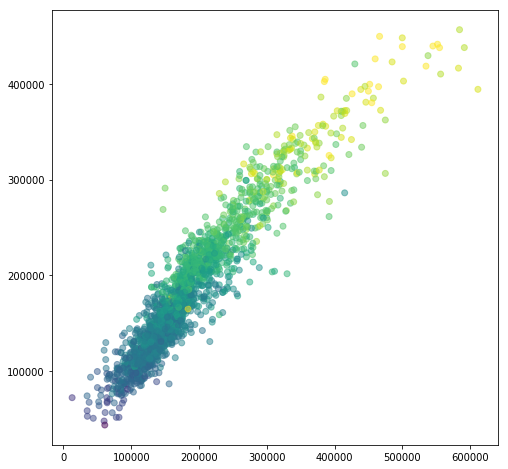

In [60]:
## Plotting the actuals against the predictions to find outliers
## Coloring model with one of my features (I looked at a few)
plt.figure(figsize=(8,8))
plt.scatter(df['SalePrice'], df['yhat'], c=df['QualMetric'], alpha=.5, cmap='viridis');

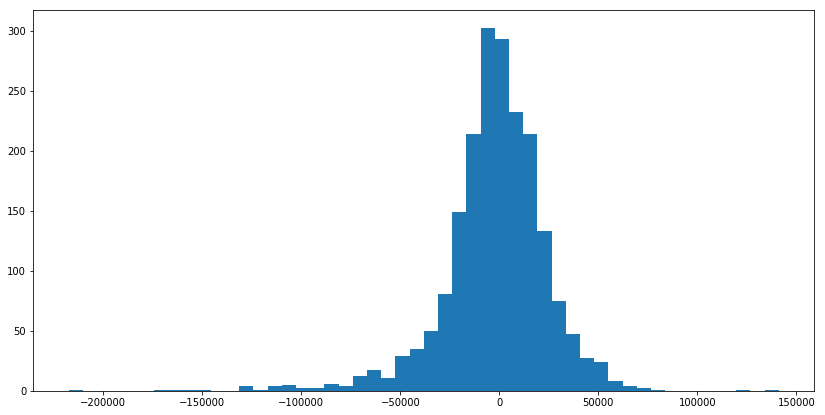

In [50]:
## Plotting errors on histogram to make sure it's normal(ish)
#### Would like to add KDE line
plt.figure(figsize=(14,7))
plt.hist(df['error'], bins=50);

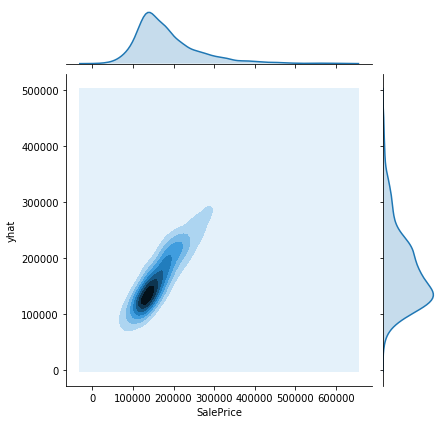

In [51]:
## I just like this visualizaiton okay.
## (Plotting distribution of actual target vs predictions similar to 1st visualization)
sns.jointplot(df['SalePrice'],
              df['yhat'],
             kind = 'kde');

In [52]:
## Creating a dataframe where I can see what is abnormal about mis-predicted values
df_std_cols = list(train.select_dtypes(include=[np.number]).columns)
df_std_data = SS.fit_transform(train.select_dtypes(include=[np.number]))
df_std = pd.DataFrame(data=df_std_data, columns=df_std_cols)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [53]:
## Storing 5 most under predicted values
under_pred5 = list(df.sort_values(by='error').head(5).index)

In [54]:
## Examining 5 most under predicted to find indications of features that drove them away from model
df_std.loc[under_pred5].mean().sort_values()

MoSold                 -0.590326
PID                    -0.588258
Neighborhood_NAmes     -0.421970
HouseAge               -0.407387
EnclosedPorch          -0.377264
BsmtFinType2           -0.330817
MSSubClass_50          -0.326885
WoodDeckSF             -0.316171
BsmtFinSF2             -0.290730
Neighborhood_Edwards   -0.273766
Neighborhood_Somerst   -0.260141
BsmtHalfBath           -0.252125
MSSubClass_30          -0.227585
KitchenAbvGr           -0.204568
Neighborhood_IDOTRR    -0.186583
Neighborhood_NoRidge   -0.154803
YrSold                 -0.133964
3SsnPorch              -0.102738
MiscVal                -0.089968
PoolArea               -0.063480
Id                     -0.060008
BsmtFullBath           -0.052676
BsmtCond               -0.032842
mansion                -0.031242
GarageCond              0.107952
BsmtFinType1            0.162968
OverallCond             0.215386
CentralAir              0.271702
ExterCond               0.306380
YearBuilt               0.407387
          

In [55]:
## Storing 5 most over predicted values
over_pred5 = list(df.sort_values(by='error').tail(5).index)

In [56]:
## Examining 5 most over predicted to find indications of features that drove them away from model
df_std.loc[over_pred5].mean().sort_values()

OverallCond            -1.052468
LotFrontage            -0.862445
YrSold                 -0.743862
HeatingQC              -0.579388
PID                    -0.551971
SalePrice              -0.504670
BsmtFullBath           -0.435418
SalePriceLog           -0.406048
BsmtFinSF1             -0.337244
HouseAge               -0.327839
MSSubClass_50          -0.326885
EnclosedPorch          -0.323780
BsmtFinType1           -0.320366
Neighborhood_OldTown   -0.293828
ScreenPorch            -0.287856
Neighborhood_Edwards   -0.273766
BsmtExposure           -0.261254
BsmtHalfBath           -0.252125
Neighborhood_NridgHt   -0.251486
MSSubClass_30          -0.227585
KitchenAbvGr           -0.204568
Neighborhood_IDOTRR    -0.186583
KitchenQual            -0.176294
Neighborhood_NoRidge   -0.154803
LowQualFinSF           -0.107977
3SsnPorch              -0.102738
MiscVal                -0.089968
MoSold                 -0.080134
PoolArea               -0.063480
BsmtCond               -0.032842
          

# 8) Running Model on Test Data<a name="RunningModel"></a>

In [57]:
## Establishing X and y for test data
test_filter = ['Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
               'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'TotalArea',
       'QualMetric', 'TotalBaths', 'PorchArea','mansion','YearRemod/Add']
X_test = test[test_filter]

## Using the power transform, which was identified as the best fit above
X_test_pt = pt.fit_transform(X_test)

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [58]:
## Adding column for predicted Sale Prices
## Taking the exponent to 'un-log' the PowerTransformer
test['SalePrice'] = np.exp(ridge.predict(X_test_pt))

In [59]:
## Exporting my two columns to CSV
test[['Id','SalePrice']].to_csv('../submissions/JLove-Submit-test.csv', index=False)